In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
puits = (0, 0)
rcapt, rcom = 2.0, 3.0
# 1.0, 1.0 # Other values to test
# 1.0, 2.0
# 2.0, 2.0
# 2.0, 3.0

In [3]:
def file_to_instance(filepath):
    '''Function that transforms a .dat file with a certain number of coordinates
    into an instance of the sensor positioning problem. The function also identifies
    if the instance is generated ramdomly or if it was created by the exclusion of
    certain cible coordinates. In the first case, the instance is generated directly
    from the given coordinates. In the second, a full grid is generated and the 
    indicated cibles are removed.
    
    Parameters:
    - filepath: string, indicates the path to a .dat file
    Returns:
    - instance: dict, tuple, int; stores the coordinates of the cibles in the instance.'''
    # read file 
    df = pd.read_csv(filepath, delimiter = "\t")
    # get the column name 
    col = df.columns[0] # it should only have one column name

    column = df[col] # get the series of the actual data 

    left, right = col.split(":") # retrieving information
    if left.strip() == 'taille de la grille complète':
        # fall into the first case: not random
        # cible removal
        N = int(right.strip("=;")) # grid size
        n = int(np.sqrt(N))

        coordinates = [(0, 0)]
        # treating the coordinates
        for el in column:
            aux = el.split(':', maxsplit=1)
            try:
                ind = int(aux[0].strip()) # this index is very much an accessory but lets keep it
                # if it is one of the string lines of the series, it will not crash 
                # makes sure we only get numerical values
            except ValueError:
                continue # if it's not numerical, moves on to the next line
            a, b = map(int, aux[1].strip(" ()").split(",")) # treats teh tuple as a string and gets the coordinates
            coordinates.append((a,b))

        # create the full instance
        instance = []
        for i in range(n):
            for j in range(n):
                if (i, j) not in coordinates:
                    instance.append((i, j))
    
    elif left.strip() == "Nombre de cibles": # Vai adicionando elemento por elemento
        instance = []
        for i in range(int(right.strip())):
            ind, a, b = df[col][i].split()
            if a != '0.00' or b != '0.00':
                instance.append((float(a.strip()),float(b.strip(" ;"))))

    return instance

In [4]:
class SensorCoverageSolver:
    def __init__(self, cibles: list[tuple[float, float]], rcapt: float, rcom: float, puits: tuple[float, float]):
        '''Builds a solver object for the placement of sensors in a grid problem.'''
        self.cibles = np.asarray(cibles)
        self.rcapt = rcapt
        self.rcom = rcom
        self.puits = np.asarray(puits)
        self.n = len(cibles)
        self.dist_matrix = self.distance_matrix()
    
    def distance_matrix(self) -> np.ndarray:
        '''Computes the distance between points in the grid.'''
        # Usando broadcasting para eficiência
        diff = self.cibles[:, np.newaxis, :] - self.cibles[np.newaxis, :, :]
        d = np.sqrt(np.sum(diff**2, axis=2))
        return d
    
    def reachable_points(self, i: int) -> set[int]:
        '''For a given point i, returns set of reachable points within R_capt.'''
        # np.where retorna uma tupla, precisamos pegar o primeiro elemento
        indices = np.where(self.dist_matrix[i, :] <= self.rcapt)[0]
        return set(indices)
    
    def communicable_points(self, i: int) -> set[int]:
        '''For a given point i, returns set of communicable points within R_com.'''
        indices = np.where(self.dist_matrix[i, :] <= self.rcom)[0]
        return set(indices)
    
    def coverage_heuristics(self) -> set[int]:
        '''Heurística para encontrar uma solução viável.'''
        
        sensors = set() # Sensores
        reachable = set() # Cibles que podem ser captadas
        communicable = set() # Sensores comunicáveis
        
        # Encontrar ponto mais próximo do puits para começar
        # podemos tentar fazer com o ponto mais longe também
        min_dist = np.inf
        start_point = -1
        for i in range(self.n):
            dist = np.linalg.norm(self.cibles[i] - self.puits)
            if dist < min_dist:
                min_dist = dist
                start_point = i
        
        # Adicionar ponto inicial
        sensors.add(start_point)
        reachable.update(self.reachable_points(start_point))
        communicable.update(self.communicable_points(start_point))
        
        # Loop principal
        while len(reachable) < self.n:
            best_point = -1
            best_new_coverage = -1
            
            # Iterar sobre os pontos comunicáveis que ainda não são sensores
            # Convertendo para lista para poder iterar
            candidates = list(communicable - sensors)
            
            for i in candidates:
                # Pontos que este sensor alcançaria
                i_reachable = self.reachable_points(i)
                # Novas cibles que seriam cobertas
                new_reachable = i_reachable - reachable
                num_new = len(new_reachable)
                
                if num_new > best_new_coverage:
                    best_new_coverage = num_new
                    best_point = i
            
            # Se não encontrou ponto que cubra novas cibles
            if best_point == -1:
                # Procurar qualquer ponto não coberto
                for i in range(self.n):
                    if i not in reachable:
                        best_point = i
                        break
            
            # Se ainda não encontrou, todos estão cobertos
            if best_point == -1:
                break
            
            # Adicionar o melhor ponto
            sensors.add(best_point)
            reachable.update(self.reachable_points(best_point))
            communicable.update(self.communicable_points(best_point))
        
        return [self.cibles[i] for i in sensors]

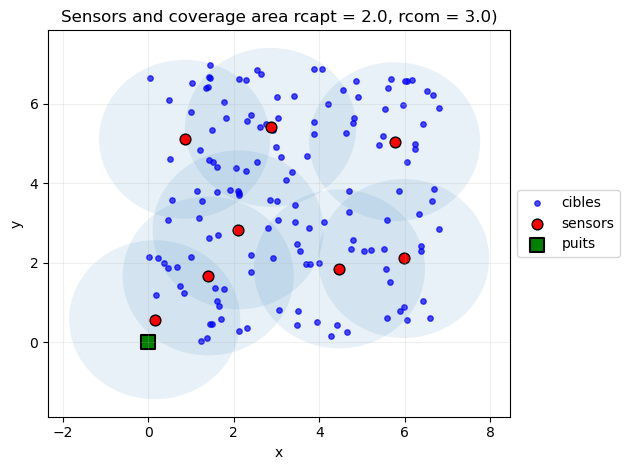

In [5]:
cibles = file_to_instance(fr"C:\Users\gabri\Desktop\ENSTA\3A SOD\Méta-Heuristiques\Gabriel_Bastianello\Projet-Meta-Heuristiques\Projet de métaheuristiques - Instances cibles générées aléatoirement\captANOR150_7_4.dat")
solver = SensorCoverageSolver(cibles, rcapt, rcom, puits)
sensors = solver.coverage_heuristics()

x, y = zip(*cibles)
x_c, y_c = zip(*sensors)

plt.figure()
for sensor_x, sensor_y in sensors:
    circle = plt.Circle((sensor_x, sensor_y), rcapt, 
                       alpha=0.1, fill=True, linewidth=0.5)
    plt.gca().add_patch(circle)

plt.scatter(x, y, color='blue', s=15, alpha=0.7, label='cibles')

if sensors:
    plt.scatter(x_c, y_c, color='red', s=60, marker='o', 
                edgecolors='black', linewidth=1, label='sensors')

plt.scatter([0], [0], color='green', s=100, marker='s', 
            edgecolors='black', linewidth=1.5, label='puits')

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Sensors and coverage area {rcapt = }, {rcom = })')
plt.grid(True, alpha=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()